In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Любая нейронная сеть это математическое выражение с параметрами, как в ЕГЭ $ y = \sqrt{R^2 -  (x - a)^2} + b $ (тут можно регулировать параметры `a`, `R`, `b`, чтобы сделать любую окружность).  
И мы хотим, чтобы это математическое выражение считало, то что мы хотим.  
У нас есть (точнее нету) функция, которую мы хотим предсказывать, которую мы хотим апроксимировать. Но у нас есть набор наблюдений поведения этой функции. Набор пар/примеров (входное значение, выходное значение) и мы хотим так подогнать параменты нашего выражения, чтобы оно давало правильные (почти) ответы на наших примерах и как следствие, работало на похожих примерах

Предположим, что это наше математическое выражение

In [1]:

def f(x, a, b):
    return a * x + b

И мы хотим, чтобы оно удовлетворяло набору примеров (точек на плоскости)  
(-1, 2)  
(2, -3)  

Для этого нам надо минимизировать разницу между выходами функции и множеством Y, варьируя параметры `a` и `b`

$loss = \sum_{i=0}^{n} (f(x_i, a, b) - y_i)^2 \underset{\text{a, b}}{\longrightarrow} min $ 

Если бы нам надо было искать минимум только по одной переменной `a` или `b`, то мы бы могли взять производную этой функции по этой переменной, найти точку минимума и все  
Но тут у нас две переменные.  
И все что мы можем сделать, этой найти производную по `a`, потом по `b` и сделать два маленьких шага в сторону, противоположную производной, чтобы уменьшить функцию

$ loss = (a * (-1) + b - 2)^2 + (a * 2 + b - (-3))^2 $  
$ loss = 5a^2 + 2b^2 + 4b + 13 + 2ab + 16a + 2b $

Найдем производную по `a`

$ \frac{d \space loss}{da} = \frac{d}{da} (5a^2 + 2b^2 + 4b + 13 + 2ab + 16a + 2b) = 10a + 2b + 16 $

И по `b`

$ \frac{d \space loss}{db} =  \frac{d}{db} (5a^2 + 2b^2 + 4b + 13 + 2ab + 16a + 2b) = 4b + 2a + 2 $


Вообще в этом случае можно просто решить систему, прировняв производные к 0. Но обычно параметров миллионы

Чтобы начать подбирать параметры, надо их рандомно инициализировать  
Пусть $a = b = 0 $

$ \frac{d \space loss}{da}(0, 0) = 16 $  
  
$ \frac{d \space loss}{db}(0, 0) = 2 $

Подвинем немного каждую переменную в сторону, обратную производной  
```
step = 0.1   
a -= 16 * step   
b -= 2 * step   
  
a = -1.6   
b = -0.2 
```

Сделаем следующий шаг

$ \frac{d \space loss}{da}(-1.6, -0.2) = -0.4 $ # Производная стала на много меньше. Из этого может следовать, что значение близко к оптимуму  
  
$ \frac{d \space loss}{db}(-1.6, -0.2) = -2 $

Го запрогаем

In [4]:
a = b = 0
step = 0.1
for _ in range(100):
    dLda = 10 * a + 2 * b + 16
    dLdb = 4 * b + 2 * a + 2
    a -= dLda * step
    b -= dLdb * step

In [5]:
a, b

(-1.6666666666666667, 0.3333333333333333)

Проверим, что получилось

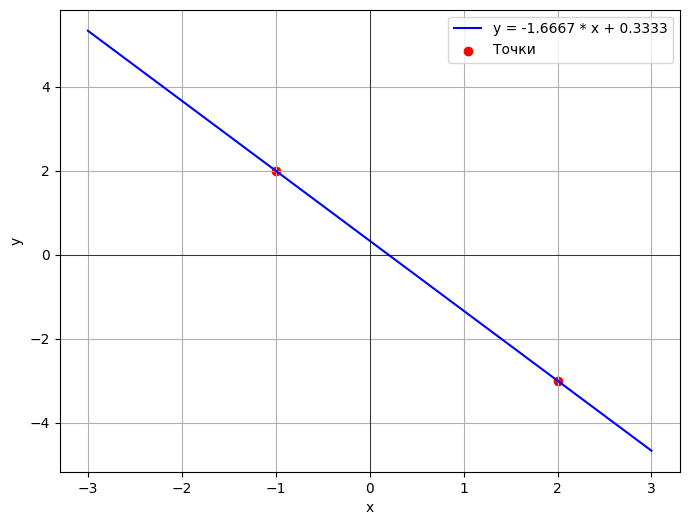

In [14]:
points = np.array([(-1, 2), (2, -3)])

x_values = np.linspace(-3, 3, 100)
y_values = a * x_values + b

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label=f'y = {a:.4f} * x + {b:.4f}', color='blue')
plt.scatter(points[:,0], points[:,1], color='red', label='Точки')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()

### Теперь давайте автоматизируем этот процесс

Нейросети представляют очень большие математические выражения.  
Давайте реализуем объект `Value`, которыми будем оперировать в наших выражениях.  
Это будет аналогом `torch.tensor` в pytorch 

У `Value` будет несколько полей.   
* `data` - числовое значение  
* `_children` - множество другиех `Value` с помощью которых было получено это значение.   
    Например если  
    ```python
    a = Value(1)
    b = Value(2)
    c = a + b
    print(c._children) # set(a, b)
    ```

Эти параметры нужны просто для дальнейшие визуализации  
* `_op` - строка в которой написано, с помощью какой операции было полученно значение. Например `"+"` или `"sigmoid"`  
* `label` - просто название переменной  

In [28]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [38]:
a = Value(-5/3, label='a')
b = Value(1/3, label='b')
x = Value(-1, label='x')
c = a * x; c.label = 'c'
y = c + b; y.label = 'y'
y

Value(data=2.0)

Тут спрятана функция, которая рисует граф операций с помощью которых было полученно какие-то `Value`. Не принципиально как она работает

In [39]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    if hasattr(n, 'grad'):
      label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad)
    else:
      label = "{ %s | data %.4f }" % (n.label, n.data)
    dot.node(name = uid, label = label, shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

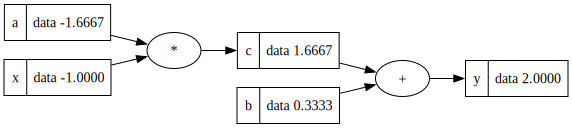

In [40]:
draw_dot(y)

Далее мы хотим для каждого `Value` посчитать по нему частную производную.  
В ml значение частной производной по параметру называется "градиент". В матанализе градиент, это вектор частных произвдных.  

Доработаем класс `Value`  
В `self.grad` мы будем хранить значение частной производной. Изначально переменная не состоит ни в каком выражении, ни на что не влиет, поэтому поставим `self.grad = 0.0`  
Далее у нас будет функция `self._backward`, которую мы будем вызывать рекурсивно у каждого `значения` в выражении, чтобы посчитать его градиент. 
```python
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
```

Предположим у нас есть выражение
```
y = a * b
F = f(y)
```
Тогда `y._children = set(a, b)`   

И допустим мы уже как-то вычислили градиент `y` и он равен `y.grad`  
Мы хотим узнать градиет у значений `a` и `b`, вызвав у них метод `._backward()`. Но по началу в этот метод ничего не делает. Надо в него что-то положить.  
По логике (и правилу взятия производной сложной функции $ \frac{dF}{da} = \frac{dF}{dy} * \frac{dy}{da} $) `a.grad` должен быть равен $ \frac{dF}{dy} * \frac{dy}{da} = y.grad * b.data $.  
Аналогично $ b.grad = \frac{dF}{dy} * \frac{dy}{db} = y.grad * a.data $.  
  
Давайте, при создании значения `y` через произведение `a * b` присваивать в метод `._backward` функцию, которая будет расчитывать значения градиентов у `children`, то есть у `a` и `b` в нашем случае.  
```python
class Value:
    def __mul__(self, other):
        # создаем `y` когда умножаем `a` на `b`
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out
```

В строках
```python
self.grad += other.data * out.grad 
other.grad += self.data * out.grad
```
мы делаем `+=`, а не `=`, потому что переменная/значение может встречается в выражении несколько раз.  
Например
`y = a * (a * b)`  
Тут производная по `a`, если считать на бумажке, получится  
$ \frac{dy}{da} = 2ba $  
  
А если считать алгоритмом  
`a.grad = y.grad * (a * b).data + (a * b).grad * b.data = y.grad * (a * b).data + (y.grad * a.data) * b.data`  
Есть преобразовать, то получится тоже самое  
`a.grad = y.grad * 2 * b * a`  

Сначала наш алгоритм посчитает градиент из первого умножения `y = a * ...`   
А потом из второго `(a * b)`  


In [41]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out

In [45]:
a = Value(3, label='a')
b = Value(5, label='b')
y = a * b; y.label ='y'
y.grad = 2.0 # предположим, что мы его нашли
y._backward()
a.grad, b.grad

(10.0, 6.0)

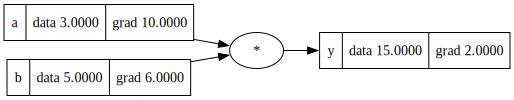

In [46]:
draw_dot(y)

Получется, что мы должны для каждой операции, которую хотим использовать с `Value` определить, как через нее будет `течь` градиент.  
Реализуем для сложения  
Там градиент у `children` будет такой же как у `родителя`
```py
class Value:
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
           self.grad += out.grad
           other.grad += out.grad
        out._backward = _backward
    
        return out
```

In [43]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
           self.grad += 1.0 * out.grad
           other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out

# Дальше добавить бэквард через все операции
# обучиться на чемто
# потом перцептрон и новые операции

In [15]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

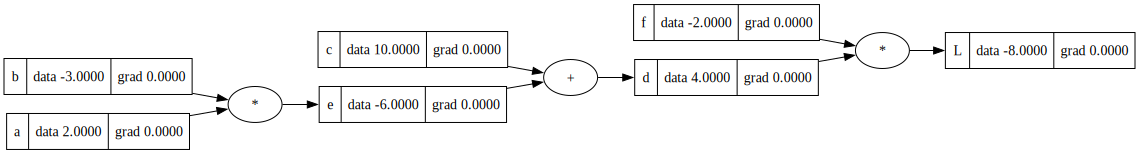

In [27]:
draw_dot(L)